In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

# 100000 and addZerso=False

# hard coded nrows
df_all = pd.read_csv('../../../diploma/multi-source-syber-security-events/flows.txt', header=None, nrows=100000)

df_all.columns = ['time', 'duration', 'source computer', 'source port', 'destination computer', 
              'destination port', 'protocol', 'packet count', 'byte count']

df = df_all

df.index = df['time']
df.drop(columns=['time'],inplace=True)
df.head()

,duration,source computer,source port,destination computer,destination port,protocol,packet count,byte count
time,,,,,,,,
1,0,C1065,389,C3799,N10451,6,10,5323
1,0,C1423,N1136,C1707,N1,6,5,847
1,0,C1423,N1142,C1707,N1,6,5,847
1,0,C14909,N8191,C5720,2049,6,1,52
1,0,C14909,N8192,C5720,2049,6,1,52


In [2]:
from helper import group_scale_data, group_scale_data_batch

groupped_data, hosts, parameters = group_scale_data(df, size_of_bin_seconds=60,
                                                    addZeros=False, doScale=True, scaler='log', verbose=1)

A total of 59 time epochs have been encountered
Scaeling...


In [3]:
groupped_data.head()

,number of flows,mean(byte count),epoch,source computer
97,20,42,1,C2270
57,1,55,1,C1697
181,1,49,1,C357
61,1,26,1,C17644
230,1,47,1,C4299


In [4]:
from emClustering import OnlineEM
from plots import plot_points, plot_results, plot_category, plot_all_categories
from kplusplus import KPlusPlus

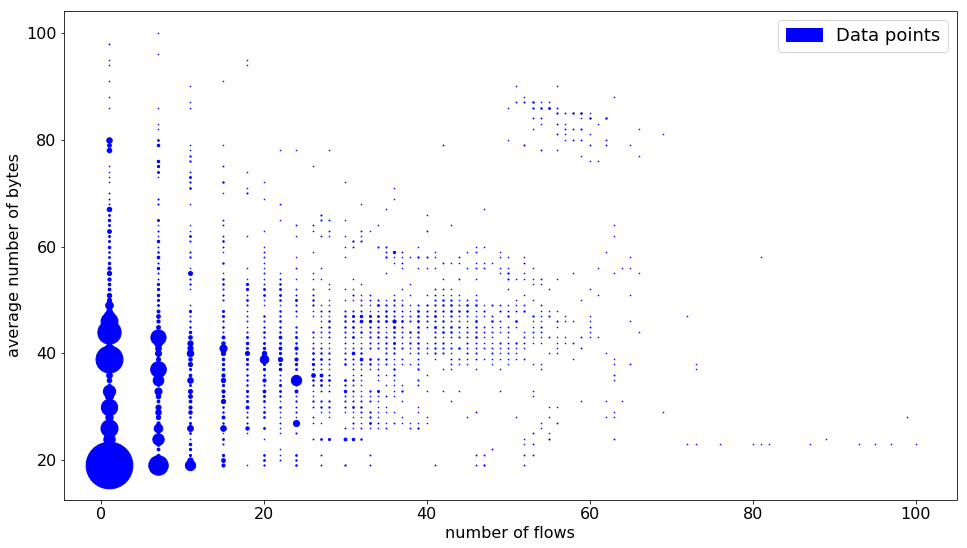

In [5]:
plot_points(groupped_data.values[:, :2])

Centers found: 1
Centers found: 2
Centers found: 3
Centers found: 4
Centers found: 5
Centers found: 6
Centers found: 7
Centers found: 8
Centers found: 9
Centers found: 10
Centers found: 11
Centers found: 12
Centers found: 13
Centers found: 14
Centers found: 15


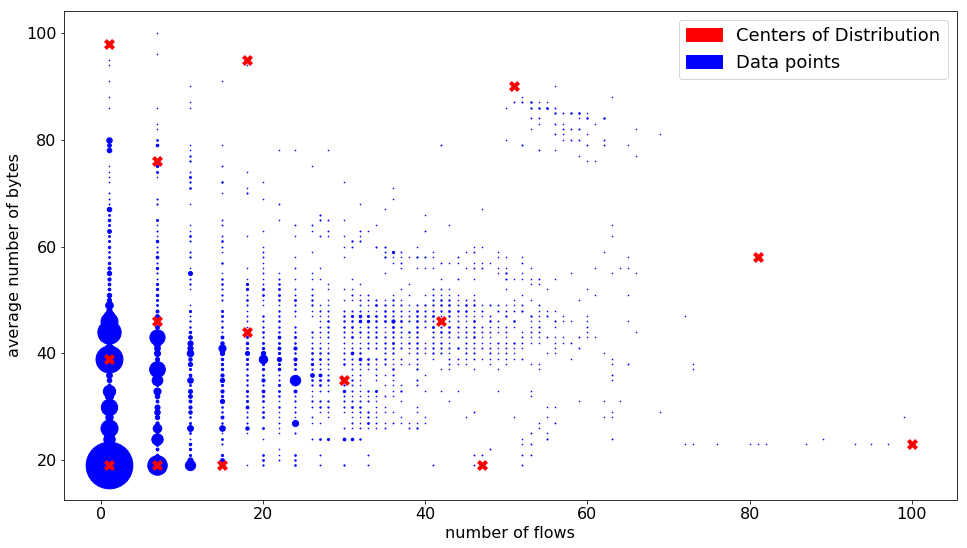

In [6]:
mixtures = 15

kplusplus = KPlusPlus(mixtures, groupped_data.values[:, :2], stochastic=False, stochastic_n_samples=3000)

kplusplus.init_centers(verbose=1)

# random initialization
onlineEM = OnlineEM([1/mixtures]*mixtures, kplusplus.centers, 500, n_clusters=8, verbose=1, update_power=0.5)

plot_points(groupped_data.values[:, :2], onlineEM)

In [7]:
data = groupped_data.values[:,[0,1,3]]

onlineEM.fit(data)

Running for data till position 500 from total 25362
Running for data till position 1000 from total 25362
Running for data till position 1500 from total 25362
Running for data till position 2000 from total 25362
Running for data till position 2500 from total 25362
Running for data till position 3000 from total 25362
Running for data till position 3500 from total 25362
Running for data till position 4000 from total 25362
Running for data till position 4500 from total 25362
Running for data till position 5000 from total 25362
Running for data till position 5500 from total 25362
Running for data till position 6000 from total 25362
Running for data till position 6500 from total 25362
Running for data till position 7000 from total 25362
Running for data till position 7500 from total 25362
Running for data till position 8000 from total 25362
Running for data till position 8500 from total 25362
Running for data till position 9000 from total 25362
Running for data till position 9500 from total 

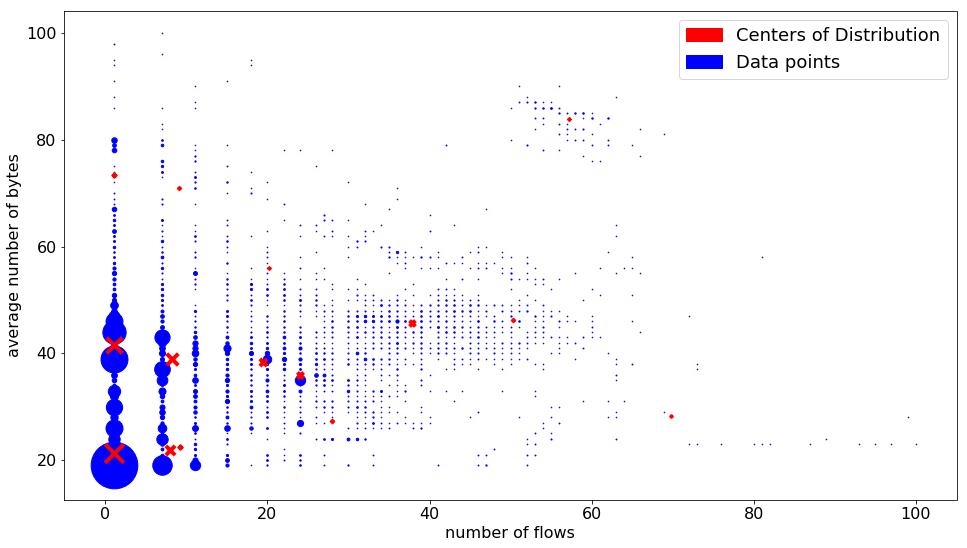

In [8]:
plot_points(groupped_data.values[:, :2], onlineEM)

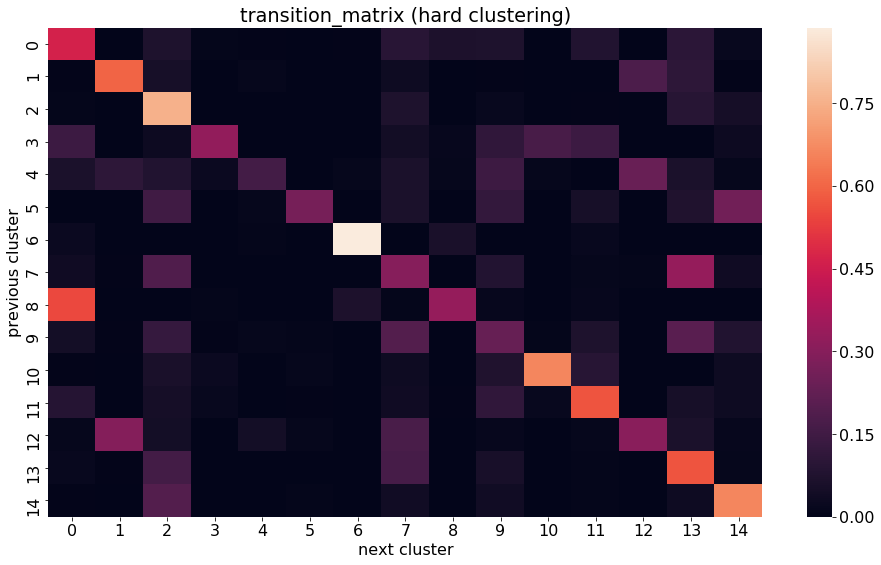

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 16, 9
rcParams['font.size'] = 16

ax = sns.heatmap(onlineEM.transition_matrix)
plt.ylabel('previous cluster')
plt.xlabel('next cluster')
plt.title('transition_matrix (hard clustering)')
plt.show()

In [11]:
onlineEM.points_per_EM_cluster

array([  945.,   311.,  8382.,    71.,    76.,    93.,   115.,  2951.,
         118.,  1321.,   151.,   820.,   186.,  5531.,  2420.])

In [12]:
onlineEM.lambdas

array([[37.77961421079974, 45.723463456580454],
       [1.00318455443645, 73.43286731122569],
       [1.0024667821193938, 21.274902756428823],
       [69.85741576810958, 28.24624913530537],
       [20.1874046664464, 55.92619368072469],
       [9.14491255530806, 22.46525710272081],
       [57.241166992533536, 83.98074093419343],
       [8.193153428259285, 38.89578152960175],
       [50.29629321912628, 46.20996918907162],
       [19.495453616537606, 38.300786513315835],
       [27.951720368155467, 27.231539342211317],
       [24.071001818907124, 35.98420462665891],
       [9.041930107547648, 70.99832741013769],
       [1.002476654936524, 41.620610181726605],
       [8.023646148191641, 21.925099472879054]], dtype=object)

In [13]:
onlineEM.gammas

array([ 0.03464427,  0.01286271,  0.34879947,  0.00358414,  0.00370945,
        0.01354284,  0.00438105,  0.13444616,  0.00759462,  0.05198006,
        0.00807768,  0.03841817,  0.00687297,  0.24524185,  0.08584456])

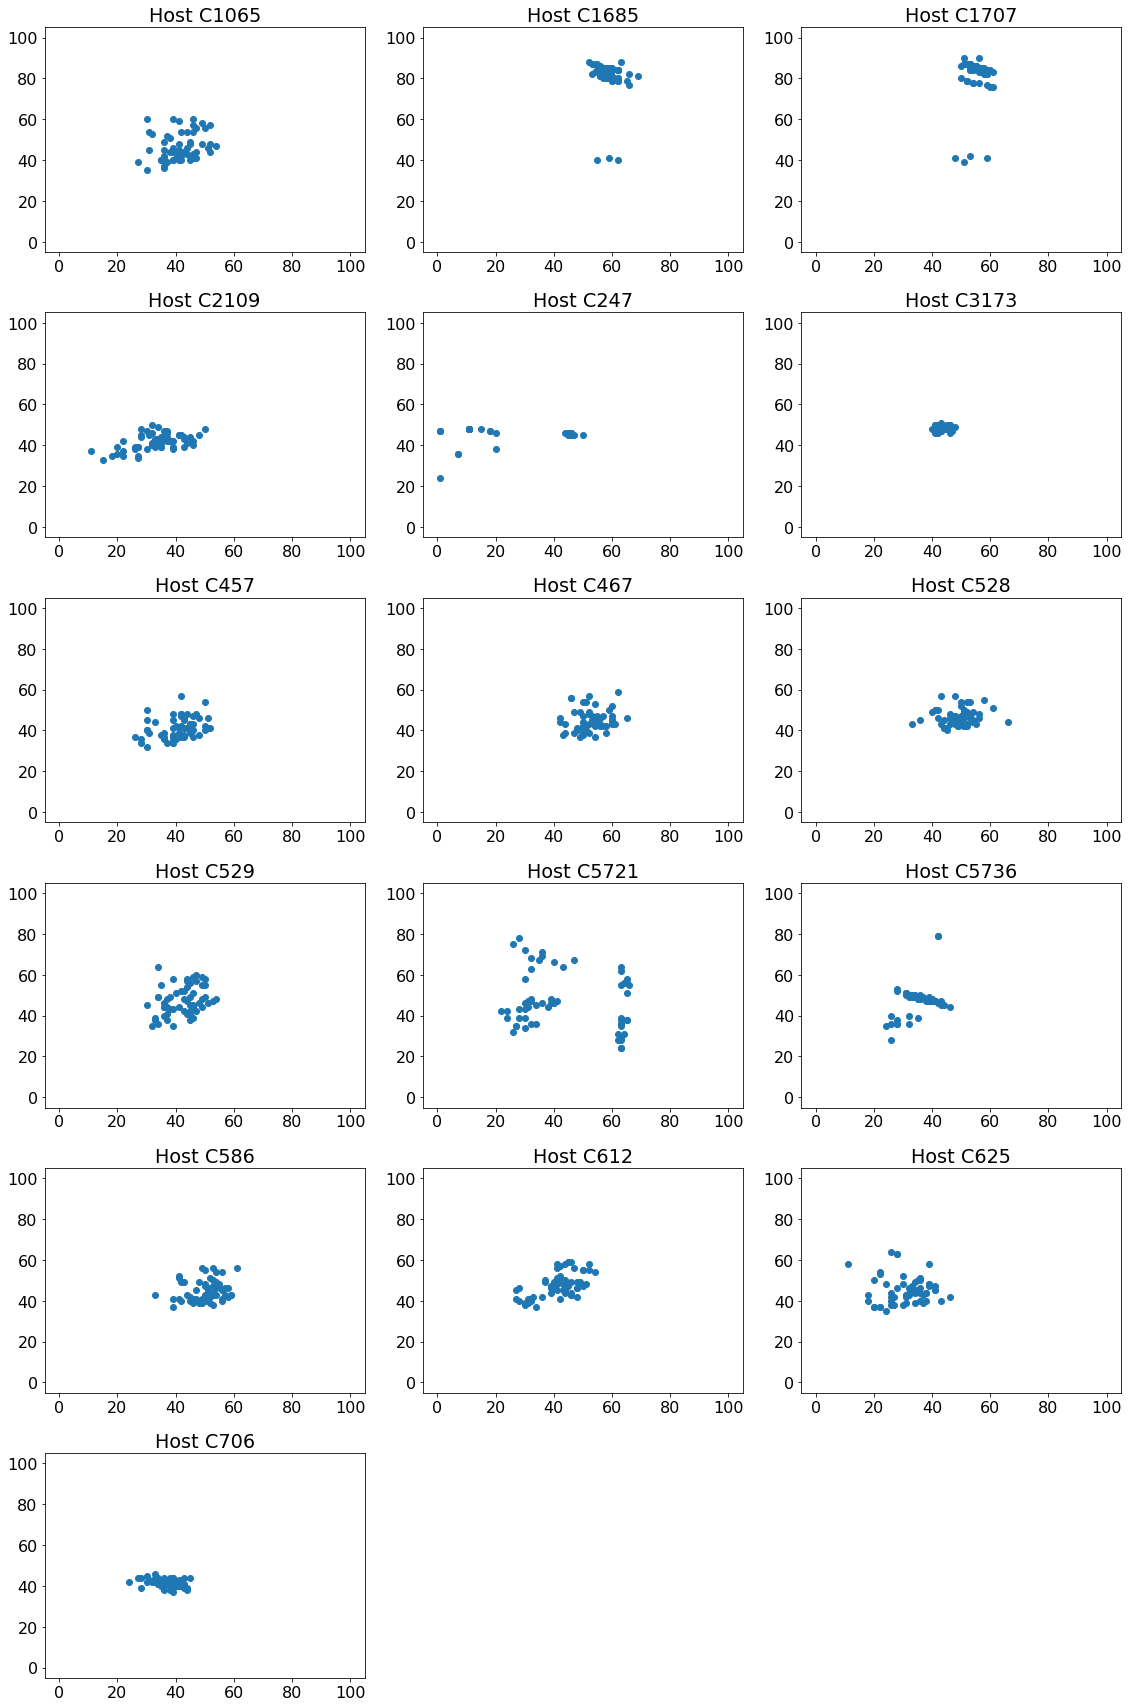

In [14]:
# Hosts in the upper cluster

temp = groupped_data[(groupped_data['number of flows'] > 40) & (groupped_data['mean(byte count)'] > 40)].groupby('source computer').count()


hosts = temp[temp['epoch'] > 3].index.values

total = len(hosts)

rcParams['figure.figsize'] = 16, (total + 2)/3 * 4
    
for i, host in enumerate(hosts):    
    plt.subplot((total + 2)/3, 3, i + 1)
    
    points = groupped_data[groupped_data['source computer'] == host].values

    plt.scatter(points[:, 0], points[:, 1])
    plt.xlim([-5, 105])
    plt.ylim([-5, 105])
    plt.title('Host ' + host)
    
plt.tight_layout()
plt.show()

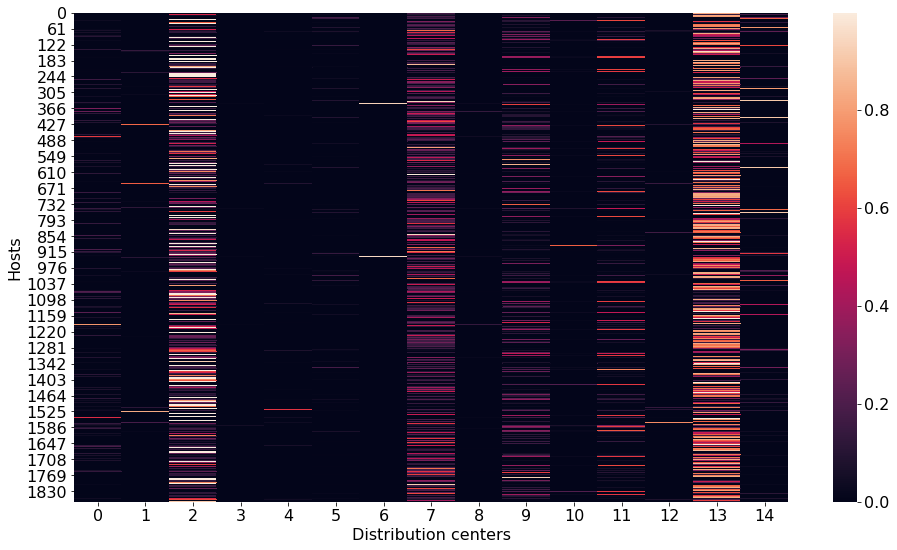

In [15]:
# HOST and clusters
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

hosts = list(set(groupped_data['source computer'].values))

from pylab import rcParams
rcParams['figure.figsize'] = 16, 9
rcParams['font.size'] = 16

heatmap_hosts = np.zeros(shape=(len(hosts), onlineEM.m))

for i, host in enumerate(hosts):
    heatmap_hosts[i] = onlineEM.hosts[host]['group']
    
ax = sns.heatmap(heatmap_hosts)
plt.ylabel('Hosts')
plt.xlabel('Distribution centers')
plt.show()

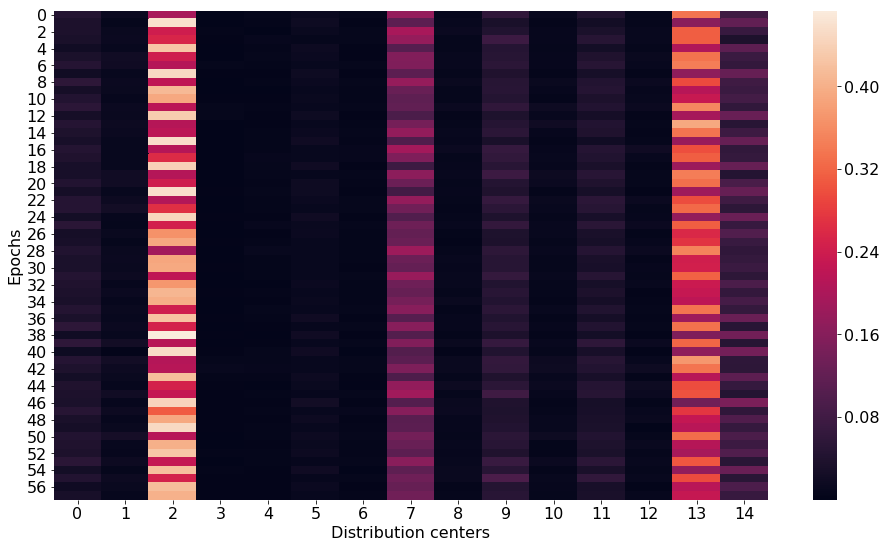

In [16]:
total_epochs = 58
time_epoch = 60

heatmap_epochs = np.zeros(shape=(total_epochs, onlineEM.m))

for i in range(total_epochs):
    df = df_all[(df_all.index > i * time_epoch) & (df_all.index <= (i + 1) * time_epoch)]
    groupped_data_epoch, _ = group_scale_data_batch(df, parameters)
    data = groupped_data_epoch.values[:,[0,1,3]]
    
    f = onlineEM.calculate_participation(data)

    temp_sum = f.sum(axis=0)
    
    heatmap_epochs[i] = temp_sum / sum(temp_sum)
    
    
ax = sns.heatmap(heatmap_epochs)
plt.ylabel('Εpochs')
plt.xlabel('Distribution centers')
plt.show()